In [ ]:
# https://www.kaggle.com/moseswmwong/electra-tweets-classifier 참조

In [ ]:
pip install torch_optimizer

     |████████████████████████████████| 72 kB 856 kB/s 


In [ ]:
pip install pytorch-lightning

     |████████████████████████████████| 913 kB 7.5 MB/s 
     |████████████████████████████████| 10.6 MB 57.6 MB/s 
     |████████████████████████████████| 829 kB 52.2 MB/s 
     |████████████████████████████████| 234 kB 46.0 MB/s 
     |████████████████████████████████| 636 kB 54.6 MB/s 
     |████████████████████████████████| 118 kB 75.8 MB/s 
     |████████████████████████████████| 1.3 MB 44.8 MB/s 
     |████████████████████████████████| 294 kB 61.1 MB/s 
     |████████████████████████████████| 142 kB 60.7 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=c3e57d5a9e5f6963c425d7886010b053e03d010da72fe284053160cbfa81e7c8
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.5.0
    Uninstalling tensorboard-2.5.0:
      Successfully uninstalled tensorboard-2.5.0
  Attempting uninstal

## **Mecab 설치**

In [ ]:
!sudo apt-get install g++ openjdk-7-jdk # Install Java 1.7+
# !sudo apt-get install python-dev; pip install konlpy     # Python 2.x
!sudo apt-get install python3-dev; pip3 install konlpy   # Python 3.x
!sudo apt-get install curl
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Package openjdk-7-jdk is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source

E: Package 'openjdk-7-jdk' has no installation candidate
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-dev is already the newest version (3.6.7-1~18.04).
python3-dev set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 448 kB 33.3 MB/s 
     |████████████████████████████████| 86 kB 7.3 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
Reading package lists... Done
Building dependency

## **Transformers 설치**

In [ ]:
pip install transformers

     |████████████████████████████████| 2.6 MB 7.6 MB/s 
     |████████████████████████████████| 895 kB 30.5 MB/s 
     |████████████████████████████████| 3.3 MB 46.4 MB/s 


In [ ]:
pip install pytorchtools

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!nvidia-smi

Sat Jul 31 12:24:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np
import pandas as pd
import os
import re
import json
import matplotlib.pyplot as plt
# from adamp import AdamP
import seaborn as sns

from tqdm import tqdm

from sklearn.model_selection import train_test_split

from konlpy.tag import Mecab, Okt
mecab = Mecab()
okt=Okt()

import torch
import torch_optimizer as optim
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import pytorch_lightning as pl

from transformers import ElectraTokenizer, ElectraForSequenceClassification,AdamW
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler


# 그래프를 출력창에서 바로 볼 수 있게함
%matplotlib inline 


In [ ]:
my_learning_rate = 3E-6 # default is 5E-5
my_adam_epsilon = 1E-8 # default is 1E-8
my_number_of_epochs = 10
my_warmup = 3
my_mini_batch_size = 128
max_len = 64

In [ ]:
"""
GPU를 사용 가능한지 여부를 True, False로 나타냄
torch.cuda.is_available()
 
GPU 이름
torch.cuda.get_device_name(0)
"""
if torch.cuda.is_available():  
    device = torch.device("cuda")
    print('I will use the GPU:', torch.cuda.get_device_name(0)) # GPU device 이름 출력
    
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

I will use the GPU: Tesla T4


In [ ]:
#################
STOPWORDSPATH ="/content/drive/MyDrive/Colab Notebooks/stopwords.txt"
#################
## Import DATA, submission file
train = pd.read_csv("/content/drive/MyDrive/DACON/topic_classification/train_data.csv", error_bad_lines=False  )
test = pd.read_csv("/content/drive/MyDrive/DACON/topic_classification/test_data.csv",error_bad_lines=False)
submission = pd.read_csv("/content/drive/MyDrive/DACON/topic_classification/sample_submission.csv",error_bad_lines=False)
topic_dict = pd.read_csv("/content/drive/MyDrive/DACON/topic_classification/topic_dict.csv",error_bad_lines=False)

In [ ]:

## preprocessing
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', }

def clean_punc(text, punct, mapping):
    for p in mapping:
        text = text.replace(p, mapping[p])
    
    for p in punct:
        text = text.replace(p, f' {p} ')
    
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}
    for s in specials:
        text = text.replace(s, specials[s])
    
    return text.strip()

cleaned_train_corpus = []
cleaned_test_corpus = []

for sent in train['title']:
    cleaned_train_corpus.append(clean_punc(sent, punct, punct_mapping))
    
for sent in test['title']:
    cleaned_test_corpus.append(clean_punc(sent, punct, punct_mapping))


def clean_text(texts):
    corpus = []
    for i in range(0, len(texts)):
        texts[i] = texts[i].replace("外人","외국인 ")
        texts[i] = texts[i].replace("日","일본 ")
        texts[i] = texts[i].replace("美","미국 ")
        texts[i] = texts[i].replace("北","북한 ")
        texts[i] = texts[i].replace("英","영국 ")
        texts[i] = texts[i].replace("中","중국 ")
        texts[i] = texts[i].replace("與","여당 ")
        texts[i] = texts[i].replace("靑","청와대 ")
        texts[i] = texts[i].replace("野","야당 ")
        texts[i] = texts[i].replace("伊","이탈리아 ")
        texts[i] = texts[i].replace("韓","한국 ")
        texts[i] = texts[i].replace("南","한국 ")
        texts[i] = texts[i].replace("獨","독일 ")
        texts[i] = texts[i].replace("佛","프랑스 ")
        texts[i] = texts[i].replace("檢","검찰 ")
        texts[i] = texts[i].replace("銀","은행 ")
        texts[i] = texts[i].replace("亞","아시아 ")
        texts[i] = texts[i].replace("人","사람 ")
        texts[i] = texts[i].replace("孫","손혜원 ")
        texts[i] = texts[i].replace("企","기업 ")
        texts[i] = texts[i].replace("前","이전 ")
        texts[i] = texts[i].replace("反","반대 ")
        texts[i] = texts[i].replace("安","안철수 ")
        texts[i] = texts[i].replace("展","전시회 ")
        texts[i] = texts[i].replace("故","사망 ")
        texts[i] = texts[i].replace("文","문재인 ")
        texts[i] = texts[i].replace("新","새로운 ")
        texts[i] = texts[i].replace("曺","조국 ")
        texts[i] = texts[i].replace("朴","박정치인 ")
        texts[i] = texts[i].replace("株","주식 ")
        texts[i] = texts[i].replace("男","남자 ")
        texts[i] = texts[i].replace("硏","연구 ")
        texts[i] = texts[i].replace("車","자동차 ")
        texts[i] = texts[i].replace("軍","군대 ")
        texts[i] = texts[i].replace("重","중공업 ")
        texts[i] = texts[i].replace("R&D","연구개발 ")
        texts[i] = texts[i].replace("문정부","문재인 정부 ")
        

        texts[i] = texts[i].replace('EU','유럽 연합 ')
        texts[i] = texts[i].replace('UAE','아랍에미리트 ')
        texts[i] = texts[i].replace('AI',"인공지능 ")
        texts[i] = texts[i].replace('AR','증강현실 ')
        texts[i] = texts[i].replace('VR',"가상현실 ")
        texts[i] = texts[i].replace('AP',"프로세서 ")
        texts[i] = texts[i].replace('CEO',"경영자 ")
        texts[i] = texts[i].replace('MOU','업무협약 ')
        texts[i] = texts[i].replace('%','퍼센트 ')
        texts[i] = texts[i].replace('5G','이동통신 ')
        texts[i] = texts[i].replace('3D','쓰리디 ')        

        # texts[i] = texts[i].replace('KBS',"방송국 ")
        # texts[i] = texts[i].replace('MBC','방송국 ')
        # texts[i] = texts[i].replace('SBS','방송국 ')
        # texts[i] = texts[i].replace('YTN','방송국 ')
        # texts[i] = texts[i].replace('EBS','방송국 ')
        # texts[i] = texts[i].replace('JTBC','방송국 ')
        # texts[i] = texts[i].replace('SKT',"기업 ")
        # texts[i] = texts[i].replace('KT','기업 ')
        # texts[i] = texts[i].replace('LGU','기업 ')
        # texts[i] = texts[i].replace('LG','기업 ')
        # texts[i] = texts[i].replace('SK','기업 ')
        # texts[i] = texts[i].replace('CJ','기업 ')
        texts[i] = texts[i].replace('IT','정보기술 ')
        # texts[i] = texts[i].replace('KBO',"야구협회 ")
        # texts[i] = texts[i].replace('NBA',"농구 ")
        # texts[i] = texts[i].replace('MLB',"야구 ")
        # texts[i] = texts[i].replace('EPL',"축구 ")
        
        texts[i] = texts[i].replace(r'[\d][도]','온도 ')      
        texts[i] = texts[i].replace(r'[\d][일]','날짜 ')  
        texts[i] = texts[i].replace(r'[\d][년]','연도 ')  
        texts[i] = texts[i].replace(r'\d.?[시]','시간 ') 
        texts[i] = texts[i].replace(r'\d.?[명]','인원 ') 
        texts[i] = texts[i].replace(r'[\d]주년','기념 ') 
        texts[i] = texts[i].replace(r'\d\d[대]','연령 ') 


        
        review = re.sub(r'[@%\\*=()/~#&\+á?\xc3\xa1\-\|\.\:\;\!\-\,\_\~\$\'\"]', '',str(texts[i])) #remove punctuation
        review = re.sub(r'\d+','', str(review))# remove number
        review = review.lower() #lower case
        review = re.sub(r'\s+', ' ', review) #remove spaces
        review = re.sub(r"^\s+", '', review) #remove space from start
        review = re.sub(r'\s+$', '', review) #remove space from the end
        review = re.sub("[一-龥]",'', review)
        corpus.append(review)
    return corpus

basic_preprocessed_train_corpus = clean_text(cleaned_train_corpus)
basic_preprocessed_test_corpus = clean_text(cleaned_test_corpus)


stopwords = [ 
                             '없', '의', '때', '만의', '보다', 's', 'x', '하다', '나다', '돼다', '되다', '이다', '싶다', '있다', '어떻다'
                ]
with open(STOPWORDSPATH) as f:
    for line in f:
        line = line.split('\t')
        stopwords.append(line.strip())

removed_stopword_train_corpus = []
removed_stopword_test_corpus = []
##########################################################################
"""
Mecab
"""
# for tagged in basic_preprocessed_train_corpus:
#     tagged= mecab.pos(tagged)
    
#     temp = []
#     for tag in tagged:
#         #일반명사, 고유명사, 동사, 형용사, 긍정지정사, 부정 지정사, 관형사, 일반부사, 체언접두사, 외국어, 한자
#         if tag[0] in stopwords or tag[1] not in ["NNG", "NNP", "VV", "VA", "VCP", "VCN", "MM", "MAG", "XPN", "SL", "SH"]:
#             continue
#         temp.append(tag[0])

#     removed_stopword_train_corpus.append(' '.join(temp))
    
# for tagged in basic_preprocessed_test_corpus:
#     tagged=mecab.pos(tagged)
    
#     temp = []
#     for tag in tagged:
#         if tag[0] in stopwords or tag[1] not in ["NNG", "NNP", "VV", "VA", "VCP", "VCN", "MM", "MAG", "XPN", "SL", "SH"]:
#             continue
#         temp.append(tag[0])

#     removed_stopword_test_corpus.append(' '.join(temp))
##########################################################################
"""
Okt
"""
for tagged in basic_preprocessed_train_corpus:
    tagged= okt.pos(tagged, stem=True,norm=True)
    
    temp = []
    for (word, pos) in tagged:
        #일반명사, 고유명사, 동사, 형용사, 긍정지정사, 부정 지정사, 관형사, 일반부사, 체언접두사, 외국어, 한자
        if (word not in stopwords ) and (pos not in ['Suffix','Josa','Determiner','Modifier']) and (len(word) != 1):
            # continue
            temp.append(word)

    removed_stopword_train_corpus.append(' '.join(temp))
    
for tagged in basic_preprocessed_test_corpus:
    tagged=okt.pos(tagged, stem=True,norm=True)
    
    temp = []
    for (word, pos) in tagged:
        if (word not in stopwords) and (pos not in ['Suffix','Josa','Determiner','Modifier']) and (len(word) != 1):
            # continue
            temp.append(word)

    removed_stopword_test_corpus.append(' '.join(temp))

##########################################################################

"""   
###############최종 전처리###################
"""
train_text = removed_stopword_train_corpus
test_text = removed_stopword_test_corpus
train_label = np.asarray(train.topic_idx)

In [ ]:
okt = Okt()

# morpheme analysis
def morp_analy(basic_preprocessed_corpus):
    cleaned_ = []
    tag_list = ['Suffix','Josa','Determiner','Modifier']
    for i in basic_preprocessed_corpus:
        i=okt.pos(i,stem=True,norm=True)
        tmp = []
        for (word, pos) in i:
            if (pos not in tag_list) and (len(word) != 1):
                tmp.append(word)
        cleaned_.append(" ".join(tmp))
    return cleaned_

In [ ]:
train['clear_title'] = train_text
test['clear_title'] = test_text

# train data와 label 데이터 설정
texts = train['clear_title']
labels = train['topic_idx']

#take a look at the first 50 training examples
for n in range(1000, 2000):
    print(texts[n], "(LABEL:", labels[n], ")")


In [ ]:
for n in range(1000, 2000):
    print(test.clear_title[n])

해남군 전국 최초 농민 수당 지급 천명 만원
홈플러스 올해 풋살 파크 이용 예상 마트 매출
게시판 kt 카카오 페이 통한 통신 요금 납부 서비스 제공
정치인 대통령 전국체전 정신 이면 어떻다 위기 이기다 종합
팽목항 세월호 분향소 떠나다 희생 사진
청와대 차기 총리 정세균 검토 김진표 카드 난항 기류 변화
오세훈 대선 가도 암초 만나다 종로 정세균 뒤지다
여자배구 vnl 이탈리아 패배 정대영 부상 악재
손흥민 토트넘 리그컵 상대 웨스트햄
즐라탄 맨유 복귀 모리뉴 감독 현재 협의
삼성 겨울 맞다 개다 노트 알파 화이트 색상 출시
ytn 보도국 김선 정치 부장 내정
sk 두산 연전 쓸다 lg 늘다 연패
커지다 카슈미르 이슈 모디 인도 총리 tv 연설 진화 나서다 종합
이산 상봉 신청 절반 이상 숨지다 해결 시한 놓치다
군대 전방 대북 확성기 방송 개시
애플 삼성 디지털 광고 비용 훨씬 많이 써다
석진욱 감독 최태웅 장병철 감독 코치 우승 해봤다
제주 산간 북부 강풍 주의보 오후 강풍 경보
베스트셀러 지난해 추다 뒤늦다 인기 계속
손흥민 리버풀 전서 경기 연속 선발 기대 리그 호골 도전
자신감 자긍심 차례 강조 건국 언급
미국 법무부 조세회피 의혹 파나마 페이 퍼스 면밀 검토
음악 거장 헤레베헤 베토벤 상상 음색 들려주다
한국 미국 트리 부대 사드 배치 준비 작업 하나
미국 리비아 주둔 병력 일시 철수 안전 우려 증폭
단독 북한 금수 잇다 탈북 해외 검열 급파 책임자 고사 처형
sk 텔레콤 노트 리니지 레볼루션 한정판 단독 출시
민주 대표 후보 주말 맞다 당권 레이스 시동
gs 건설 부산 마린시티 평균 대다 청약 마감
축구 대표팀 정우영 요청 이유 간절하다 때문
시진핑 왕치산 다보스 포럼 트럼프 전망
선민 결승골 인천 서울 꺾다 경기 시즌
lg 내일 예약판매 이통 사은 경쟁
skt cj 헬로비전 무산 생각 않다 기대
kt 연말 맞다 네트워크 특별 대책 마련
정청 남다 시간 많다 않다 합치다 최강 드림팀
민주 진실 제대로 밝히다 제주 아픔 끝내다
정무 gm 사태 추궁

In [ ]:
train.

,index,title,topic_idx,clear_title
45554,45554,건보공단 고객센터 직원 50% 열 나도 휴식 못해,2,건보 공단 고객 센터 직원 퍼센트 나다 휴식 하다
45555,45555,공항·항공 근로자의 한시적 해고금지를,2,공항 항공 근로자 의 한시 해고 금지
45556,45556,패륜 살인마일까 마녀사냥 희생자일까…신간 리지,3,패륜 살인마 이다 마녀사냥 희생 이다 신간 리지
45557,45557,추신수 타격감 좋은데…텍사스오클랜드전 우천 순연,5,추신수 격감 좋다 텍사스 오클랜드 우천 순연
45558,45558,플라멩구 대표 루에다 감독 칠레축구대표팀 안가고 잔류한다,5,플라멩구 대표 감독 칠레 축구 대표팀 가다 잔류 하다
...,...,...,...,...
45649,45649,KB금융 미국 IB 스티펠과 제휴…선진국 시장 공략,1,kb 금융 미국 ib 스티펠 제휴 선진국 시장 공략
45650,45650,1보 서울시교육청 신종코로나 확산에 개학 연기·휴업 검토,2,서울시 교육청 신종 코로나 확산 개학 연기 휴업 검토
45651,45651,게시판 키움증권 2020 키움 영웅전 실전투자대회,1,게시판 키우다 증권 키우다 영웅 실전 투자 대회
45652,45652,답변하는 배기동 국립중앙박물관장,2,답변 하다 기동 국립 중앙 박물관


In [ ]:
"""
Electra is selected here, its pretraining method is more advanced than BERT's MLM. 
AdamW is Adam with weight decay correction.
"""
tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-base-v3-discriminator") 
model = ElectraForSequenceClassification.from_pretrained("monologg/koelectra-base-v3-discriminator",num_labels=7) #let's try out electra's base discriminator


# tensor를 만든후 GPU에 할당하고 싶을 때  

# a = torch.tensor([1., 2.], device=cuda)
 
# b = torch.tensor([1., 2.]).cuda()

# b2 = torch.tensor([1., 2.]).to(device=cuda)


# 아니면 Model을 선언후 모든 parameter를 
# model.cuda()를 통해 GPU에 로딩할 수 있음


model.cuda()

Some weights of the model checkpoint at monologg/koelectra-base-v3-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: 

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(35000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

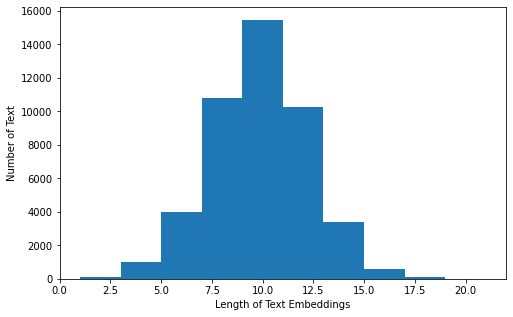

In [ ]:
import matplotlib.pyplot as plt
def plot_sentence_text_length(text_list, tokenizer):
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t), text_list))
    tokenized_texts_len = list(map(lambda t: len(t), tokenized_texts))
    fig, ax = plt.subplots(figsize=(8, 5));
    ax.hist(tokenized_texts_len);
    ax.set_xlabel("Length of Text Embeddings");
    ax.set_ylabel("Number of Text");
    return
plot_sentence_text_length(texts, tokenizer)

In [ ]:
indices=tokenizer.batch_encode_plus(texts,
                                    max_length=max_len,
                                    add_special_tokens=True, 
                                    return_attention_mask=True,
                                    pad_to_max_length=True,
                                    truncation=True)

# bert와 달리(bert는 3개) input data가 2개임

input_ids=indices["input_ids"]
attention_masks=indices["attention_mask"]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:

"""
input_ids=indices["input_ids"]
attention_masks=indices["attention_mask"]
"""
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=42, test_size=0.2)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=42, test_size=0.2)

In [ ]:
type(validation_inputs)

list

In [ ]:

# 만들어진 모든 data를 torch.tensor을 통해 tensor로 변환
# torch.long 은  np.int64 와 같음

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels, dtype=torch.long)
validation_labels = torch.tensor(validation_labels.tolist(), dtype=torch.long) # list 변환 해줘야함
train_masks = torch.tensor(train_masks, dtype=torch.long)
validation_masks = torch.tensor(validation_masks, dtype=torch.long)

In [ ]:

# pytorch는  torch.utils.data.Dataset으로 Custom Dataset을 만들고, 
# torch.utils.data.DataLoader로 데이터를 불러옴 

batch_size = my_mini_batch_size

"""Create the DataLoader for our training set."""
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

#### DataLoader ###
# DataLoader를 통해 반복분을 돌리면  (batch_size, *(data.shape))의 형태의 Tensor로 데이터가 반환
# sampler : index를 컨트롤하는 방법, 즉 데이터의 index를 원하는 방식대로 조정
# sampler option 

# SequentialSampler : 항상 같은 순서
# RandomSampler : 랜덤, replacemetn 여부 선택 가능, 개수 선택 가능

# SubsetRandomSampler : 랜덤 리스트, 위와 두 조건 불가능
# WeigthRandomSampler : 가중치에 따른 확률
# BatchSampler : batch단위로 sampling 가능
# DistributedSampler : 분산처리 (torch.nn.parallel.DistributedDataParallel과 함께 사용)


""" Create the DataLoader for our validation set."""
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data) 
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
for n, p in model.named_parameters():
    print(n)
    print(p)

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = my_learning_rate, #args.learning_rate
                  eps = my_adam_epsilon  #args.adam_epsilon

                )
# optimizer = optim.RAdam(
#     model.parameters(),
#     lr= 3e-6,
#     betas=(0.9, 0.999),
#     eps=1e-8,
#     weight_decay=0,
# )

"""
my_learning_rate = 3E-6 # default is 5E-5
my_adam_epsilon = 1E-8 # default is 1E-6
my_number_of_epochs = 7
my_warmup = 3
my_mini_batch_size = 128

"""


# epoch 수 설정
epochs = my_number_of_epochs

# Total number of training steps is number of batches * number of epochs.
# batchs * epoch 수 만큼의 훈련을 함
total_steps = len(train_dataloader) * epochs

""" warmup
내가 정한 learning rate가 0.01이라고 한다면 처음 10 step 동안은 
0.001, 0.002, 0.003 ~ 0.01까지 선형적으로 조금씩만 증가하는 learning rate을 사용

이러한 방식은 warmup step을 따로 정해줘야 함
"""

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = my_warmup, 
                                            num_training_steps = total_steps)

In [ ]:

#about evalution mert - here we use accuracy, which is good enough because the data is
#is binary classified and distribution is pretty even between positive and negative
#however better evaluation should be use later F1 or AUC ROC because emergency are
#events rare tweets

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

### **Early Stopping**

## **Training**

In [ ]:
import random

# Base on GLUE from huggingface, this is classification problem best suit our problem, here, look at the
# example Python code from hungingface gtihub, here is the here training loop

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128



# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...

for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        # Progress update every 100 batches.
        if step % 50 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # `batch` contains three pytorch tensors: [0]: input ids ,[1]: attention masks,[2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Clear any previously calculated gradients.
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Evaluate the model on this training batch.
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        loss = outputs[0]

        # Accumulate the training loss over all of the batches 
        total_loss += loss.item()
        loss.backward()

        # Clip the norm of the gradients to 1.0. to prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)       
     # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)
   

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))
      
print("")
print("Training complete!")




======== Epoch 1 / 10 ========
Training...
  Batch    50  of    286.    Elapsed: 0:00:59.
  Batch   100  of    286.    Elapsed: 0:01:59.
  Batch   150  of    286.    Elapsed: 0:03:00.
  Batch   200  of    286.    Elapsed: 0:04:03.
  Batch   250  of    286.    Elapsed: 0:05:05.

  Average training loss: 0.36
  Training epoch took: 0:05:50

======== Epoch 2 / 10 ========
Training...
  Batch    50  of    286.    Elapsed: 0:01:03.
  Batch   100  of    286.    Elapsed: 0:02:05.
  Batch   150  of    286.    Elapsed: 0:03:08.
  Batch   200  of    286.    Elapsed: 0:04:11.
  Batch   250  of    286.    Elapsed: 0:05:14.

  Average training loss: 0.34
  Training epoch took: 0:05:58

======== Epoch 3 / 10 ========
Training...
  Batch    50  of    286.    Elapsed: 0:01:03.
  Batch   100  of    286.    Elapsed: 0:02:06.
  Batch   150  of    286.    Elapsed: 0:03:09.
  Batch   200  of    286.    Elapsed: 0:04:12.
  Batch   250  of    286.    Elapsed: 0:05:15.

  Average training loss: 0.33
  Traini

In [ ]:
# Validation
print("")
print("Running Validation...")

t0 = time.time()
model.eval()

preds=[]
true=[]

# Tracking variables 
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0


# Evaluate data for one epoch
for batch in validation_dataloader:
    
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():        

        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    
    # Get the "logits" output by the model. The "logits" are the output values prior to applying an activation function like the softmax.
    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    preds.append(logits)
    true.append(label_ids)
    # Calculate the accuracy for this batch.
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    # Accumulate the total accuracy.
    eval_accuracy += tmp_eval_accuracy

    # Track the number of batches
    nb_eval_steps += 1

    
valid_flat_predictions = [item for sublist in preds for item in sublist]
# Report the final accuracy for this validation run.
print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("  Validation took: {:}".format(format_time(time.time() - t0)))
    


Running Validation...
  Accuracy: 0.88
  Validation took: 0:00:32


In [ ]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in preds for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
valid_flat_predictions = np.argmax(valid_flat_predictions, axis=1).flatten()
# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true for item in sublist]

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(flat_predictions,flat_true_labels))

              precision    recall  f1-score   support

           0       0.88      0.81      0.84      1083
           1       0.83      0.84      0.83      1210
           2       0.74      0.81      0.77      1350
           3       0.89      0.87      0.88      1142
           4       0.94      0.90      0.92      1540
           5       0.96      0.96      0.96      1443
           6       0.91      0.90      0.90      1363

    accuracy                           0.88      9131
   macro avg       0.88      0.87      0.87      9131
weighted avg       0.88      0.88      0.88      9131



In [ ]:
text1 = test['clear_title']

indices1=tokenizer.batch_encode_plus(text1,
                                     max_length=32,
                                     add_special_tokens=True, 
                                     return_attention_mask=True,
                                     pad_to_max_length=True,
                                     truncation=True)
input_ids1=indices1["input_ids"]
attention_masks1=indices1["attention_mask"]

prediction_inputs1= torch.tensor(input_ids1)
prediction_masks1 = torch.tensor(attention_masks1)


# Set the batch size.  
batch_size = my_mini_batch_size

# Create the DataLoader.
prediction_data1 = TensorDataset(prediction_inputs1, prediction_masks1)
prediction_sampler1 = SequentialSampler(prediction_data1)
prediction_dataloader1 = DataLoader(prediction_data1, sampler=prediction_sampler1, batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs1)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions = []

# Predict 
for batch in prediction_dataloader1:

  # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
    b_input_ids1, b_input_mask1 = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs1 = model(b_input_ids1, token_type_ids=None, 
                      attention_mask=b_input_mask1)

    logits1 = outputs1[0]

  # Move logits and labels to CPU
    logits1 = logits1.detach().cpu().numpy()
  
  
  # Store predictions and true labels
    predictions.append(logits1)

flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions_1 = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

Predicting labels for 9,131 test sentences...


In [ ]:
import torch.nn.functional as F

In [ ]:
z = torch.FloatTensor(flat_predictions_1)

In [ ]:
flat_predictions_1[0]

array([ 1.505871 ,  1.4777113,  2.4759245,  1.2405742, -2.2254293,
       -2.858063 , -2.8733413], dtype=float32)

In [ ]:
z[0]

tensor([ 1.5059,  1.4777,  2.4759,  1.2406, -2.2254, -2.8581, -2.8733])

In [ ]:
probs_1 = F.softmax(z, dim=1)

In [ ]:
probs_1 = (probs_1).tolist()

In [ ]:
probs_1[0]

[0.18428008258342743,
 0.17916320264339447,
 0.48614662885665894,
 0.14133882522583008,
 0.004415655508637428,
 0.002345557324588299,
 0.00230999244377017]

In [ ]:
flat_predictions

array([2, 3, 2, ..., 3, 2, 6])

In [ ]:
flat_predictions_1

[array([ 1.505871 ,  1.4777113,  2.4759245,  1.2405742, -2.2254293,
        -2.858063 , -2.8733413], dtype=float32),
 array([-1.4837884 , -1.4824746 ,  0.08530011,  5.4460216 , -1.093206  ,
        -1.4668216 , -1.7527936 ], dtype=float32),
 array([ 1.9287617 ,  0.3301484 ,  3.2935312 , -1.2806698 , -1.5973413 ,
        -2.888597  , -0.66524863], dtype=float32),
 array([ 1.7738097 , -1.0229238 ,  3.2339792 ,  0.40193725, -1.1233711 ,
        -2.5238118 , -1.7681172 ], dtype=float32),
 array([-1.3171843 , -1.78426   ,  0.31573156,  5.438712  , -1.1474555 ,
        -1.5382493 , -1.678457  ], dtype=float32),
 array([ 3.8548443 , -0.29155168,  0.96443695,  0.45288122, -1.93079   ,
        -1.704999  , -2.666107  ], dtype=float32),
 array([-1.3336425 , -1.4163071 , -0.95662004, -1.4397794 ,  0.3671136 ,
         5.9870024 , -1.0391814 ], dtype=float32),
 array([-1.5713134 , -1.7063481 ,  0.3498783 ,  5.1626782 , -0.61075234,
        -2.0334952 , -1.5496694 ], dtype=float32),
 array([-1.6886

In [ ]:
i, j, k=  [], [], []
m, n, o = [], [], []
l = []
for row in probs_1:
  i.append(row[0])
  j.append(row[1])
  k.append(row[2])
  l.append(row[3])
  m.append(row[4])
  n.append(row[5])
  o.append(row[6])


In [ ]:
submission_1 = submission
submission_1['0'] = i
submission_1['1'] = j
submission_1['2'] = k
submission_1['3'] = l
submission_1['4'] = m
submission_1['5'] = n
submission_1['6'] = o

In [ ]:
submission_1.topic_idx = flat_predictions

In [ ]:
submission_1[:12]

,index,topic_idx,0,1,2,3,4,5,6
0,45654,2,0.184280,0.179163,0.486147,0.141339,0.004416,0.002346,0.002310
1,45655,3,0.000969,0.000970,0.004652,0.990253,0.001432,0.000985,0.000740
2,45656,2,0.189768,0.038367,0.742906,0.007663,0.005583,0.001535,0.014179
3,45657,2,0.174854,0.010668,0.753041,0.044348,0.009648,0.002378,0.005063
4,45658,3,0.001151,0.000722,0.005894,0.989144,0.001364,0.000923,0.000802
5,45659,0,0.898412,0.014214,0.049910,0.029924,0.002759,0.003458,0.001323
6,45660,5,0.000657,0.000605,0.000958,0.000591,0.003599,0.992709,0.000882
7,45661,3,0.001172,0.001024,0.008002,0.984806,0.003062,0.000738,0.001197
8,45662,4,0.000531,0.000718,0.001813,0.000437,0.992679,0.000746,0.003076
9,45663,4,0.014375,0.202584,0.008760,0.004348,0.759970,0.003161,0.006803


In [ ]:
submission = pd.read_csv("/content/drive/MyDrive/DACON/topic_classification/sample_submission.csv",error_bad_lines=False)
# pred = np.argmax(predictions, axis = 1)
submission.topic_idx = flat_predictions
submission.sample(3)

#submission.to_csv(path, index = False)

,index,topic_idx
4043,49697,6
3573,49227,6
4505,50159,3


In [ ]:
submission

,index,topic_idx
0,45654,2
1,45655,3
2,45656,2
3,45657,2
4,45658,3
...,...,...
9126,54780,3
9127,54781,2
9128,54782,3
9129,54783,2


In [ ]:
# pred = xgb_clf.predict(X_valid)
crosstab = pd.crosstab(validation_labels, valid_flat_predictions, rownames=['real'], colnames=['pred'])
crosstab

pred,0,1,2,3,4,5,6
real,,,,,,,
0,874,44,38,18,13,4,4
1,107,1016,62,9,19,9,8
2,62,105,1097,92,41,10,76
3,22,16,62,993,17,3,9
4,11,12,9,19,1392,18,27
5,5,3,18,9,18,1392,6
6,2,14,64,2,40,7,1233


In [ ]:
submission_1.to_csv('/content/koelectra_a3.csv',index = False)
# submission.to_csv('bert_baseline_1.csv',index = True)

In [ ]:
submission.to_csv('/content/koelectra_n3.csv',index = False)
# submission.to_csv('bert_baseline_1.csv',index = True)

In [ ]:
!pip install /content/dacon_submit_api-0.0.4-py3-none-any.whl

Processing ./dacon_submit_api-0.0.4-py3-none-any.whl
dacon-submit-api is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


In [ ]:
from dacon_submit_api import dacon_submit_api 

result = dacon_submit_api.post_submission_file(
'/content/koelectra_n3.csv', # 파일경로
'1062a21faea5f93abd16f85ec56b813fd80b027d8c7ecf64e4fddff20f489dec',  # 개인토큰
'235747', # 대회 id
'Healthy Guys',  # 팀이름
'koelectra_n3') # 노트

{'isSubmitted': True, 'detail': 'Success'}
